In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Funciones auxiliares


In [2]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

Modelo word2vec

#1 Datos:
Ingesta de la matriz `noticias.csv`:
*	`new_id`: Identificador único de noticias
*	`news_url_absolute`: Url de la noticia encontrada
*	`news_init_date`: Fecha mínima del intevalo de tiempo al que pertenece la noticia
*	`news_final_date`: Fecha máxima del del intevalo de tiempo al que pertenece la noticia
*	`news_title`:Título relacionado a la noticia
*	`news_text_content`: Texto contenido de la noticia

In [3]:
import pandas as pd
import numpy as np

# leer el archivo noticias.csv
noticias = pd.read_csv('/content/drive/MyDrive/Integrador/noticias_prep.csv')

In [4]:
noticias.head()

,Unnamed: 0,news_id,news_url_absolute,news_init_date,news_final_date,news_title,news_text_content,clean_text
0,0,news10006,https://www.bluradio.com/economia/precio-dolar...,2022-07-30,2022-08-14,Precio dolar hoy: la cotizacion de la divisa a...,"Este martes, 2 de agosto, el dolar alcanzo un ...",martes agosto dolar alcanzo precio maximo mini...
1,1,news10011,https://www.semana.com/economia/macroeconomia/...,2022-07-30,2022-08-14,Es cierto: El presidente Gustavo Petro quiere ...,No hay nada mas permanente que lo temporal y a...,ma permanente temporal asi ocurrio impuesto gr...
2,2,news10015,https://elcomercio.pe/respuestas/que/gustavo-p...,2022-07-30,2022-08-14,Gustavo Petro: ?Que dice el informe final de s...,El equipo de empalme del gobierno del presiden...,equipo empalme gobierno presidente electo gust...
3,3,news10028,https://www.lanacion.com.ar/estados-unidos/cua...,2022-07-30,2022-08-14,Cuanto cuesta y como enviar dinero de Estados ...,?Buscas opciones para el envio de dinero de Es...,buscas opciones envio dinero unidos mexico pai...
4,4,news10029,https://www.lanacion.com.ar/estados-unidos/com...,2022-07-30,2022-08-14,Como enviar dinero de Estados Unidos a otros p...,?Buscas opciones para el envio de dinero de Es...,buscas opciones envio dinero unidos mexico pai...


In [5]:
noticias["news_text_content"][3]

'?Buscas opciones para el envio de dinero de Estados Unidos a Mexico y otros paises ? Hay varias modalidades para que las remesas, que son el dinero que los migrantes y trabajadores envian a sus paises de origen, lleguen a los bolsillos de sus seres queridos. A continuacion, encontraras la cotizacion de este viernes 12 de agosto en Western Union , una de las plataformas mas utilizadas y con mayor cobertura en America Latina. En el periodo de enero a junio de 2022, el 98,8 por ciento del total de los ingresos por remesas se realizo a traves de transferencias electronicas , en efectivo, especie y money orders. Recuerda que, antes de elegir cualquier servicio, tienes que preguntar cual es la comision que te cobraran o si incluye otros cargos. Si el envio no es urgente, las opciones no inmediatas son mas baratas. Entre las empresas mas usadas para el envio de remesas de Estados Unidos, se encuentran Western Union, MoneyGram y Vigo . Cotizacion de remesas a Mexico desde Western Union del 12

In [6]:
noticias["clean_text"][3]

'buscas opciones envio dinero unidos mexico paises varias modalidades remesas dinero migrantes trabajadores envian paises origen lleguen bolsillos seres queridos continuacion encontraras cotizacion viernes agosto western union plataformas ma utilizadas mayor cobertura america latina periodo enero junio ciento total ingresos remesas realizo trave transferencias electronicas efectivo especie money order recuerda elegir cualquier servicio preguntar comision cobraran si incluye cargo si envio urgente opciones inmediatas ma baratas empresas ma usadas envio remesas unidos encuentran western union moneygram vigo cotizacion remesas mexico western union agosto caso cobro agencia cargo transferencia dolares cuenta bancaria cotizacion remesas colombia western union agosto caso cobro agencia cargo transferencia dolares cuenta bancaria dolar cop cotizacion remesas argentina western union agosto caso cobro agencia cargo transferencia dolares cuenta bancaria envios dinero unidos latinoamerica pueden 

## Eliminar noticias vacias

In [7]:

print(f"Tamaño del dataset: {noticias.shape}")
empty_news = noticias["clean_text"].isnull().sum()
print(f"Cantidad de noticias vacias: {empty_news}")
noticias = noticias.dropna().reset_index()
print(f"Tamaño del dataset válido: {noticias.shape}")

Tamaño del dataset: (23377, 8)
Cantidad de noticias vacias: 49
Tamaño del dataset válido: (23328, 9)


In [8]:
raw_categories = pd.read_csv('/content/drive/MyDrive/Integrador/dict_top_words.csv')  
category_list = raw_categories.category.unique()
categories = pd.DataFrame()
for category in category_list:
  keywords = raw_categories.keyword[raw_categories.category == category].reset_index(drop=True)
  keywords = keywords.rename(category)
  categories = pd.concat([categories, keywords], axis=1)

categories.tail(100)

,regulaciones,innovacion,sostenibilidad,macroeconomia,reputacion,alianzas
0,petro,universidad,agua,produccion,compania,negocios
1,bogota,investigacion,energia,banco,servicio,paz
2,capital,tecnologia,programa,dolares,noticias,marca
3,ley,web,calidad,mexico,clave,alianza
4,educacion,analisis,recursos,ministerio,nombre,relacionados
...,...,...,...,...,...,...
57,iniciativas,NaN,NaN,NaN,opinion,NaN
58,naciones,NaN,NaN,NaN,cifra,NaN
59,regiones,NaN,NaN,NaN,vision,NaN
60,promover,NaN,NaN,NaN,alcanzar,NaN


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True, 
                        max_df=0.15,
                        min_df=0.05
                       )

news_tfidf = tfidf.fit_transform(noticias["clean_text"])

news_tfidf = pd.DataFrame(news_tfidf.toarray(), 
                        columns=tfidf.get_feature_names_out())
news_tfidf.head()
print(f"Palabras noticia 1: {news_tfidf.columns[news_tfidf.apply(np.flatnonzero, axis=1)[0]]}")
print(f"Tamaño de la matriz TF-IDF:{news_tfidf.shape}")

Palabras noticia 1: Index(['cinco', 'inflacion', 'interesar', 'martes', 'maximo', 'precio',
       'representa', 'tasa', 'viernes'],
      dtype='object')
Tamaño de la matriz TF-IDF:(23328, 658)


In [10]:
news_tfidf.head()

,abril,acceder,acceso,accion,acciones,actividad,actividades,activos,actual,actualmente,...,ver,verde,via,video,viene,viernes,vision,vista,visto,web
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.282086,0.0,0.0,0.0,0.000000
1,0.106313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086993,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053386,0.0,...,0.0,0.0,0.0,0.0,0.061876,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.046297,0.0,0.0,0.0,0.047493
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.046036,0.0,0.0,0.0,0.047225


In [11]:
from gensim.models import Word2Vec
import time

train_sentences = noticias["clean_text"].str.split()
start_time = time.time()

model = Word2Vec(sentences=train_sentences, 
                 sg=1, 
                 vector_size =100,  
                 workers=4)

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 5.42 mins


Descomposicion SVD de la matriz TF-IDF

* U: Documento vs tema
* Sigma: Relevancia de cada tema
* VT: Relacion tema vs palabra


In [12]:
words = np.array(tfidf.get_feature_names_out())
from sklearn.decomposition import TruncatedSVD
n_topics = 5
lsa_obj = TruncatedSVD(n_components=n_topics, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(news_tfidf) # U*Sigma
Sigma = lsa_obj.singular_values_
V_T = lsa_obj.components_.T

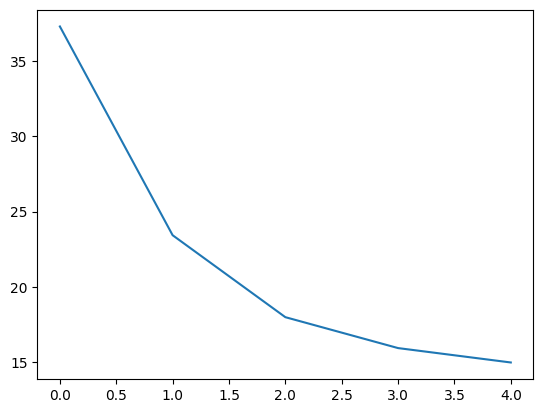

In [14]:
plt.plot(Sigma)

In [15]:
print(tfidf_lsa_data[0]) # Valores negativos! Interpretabilidad?

[ 0.11333568 -0.01672846 -0.06986743  0.23479251  0.06194696]


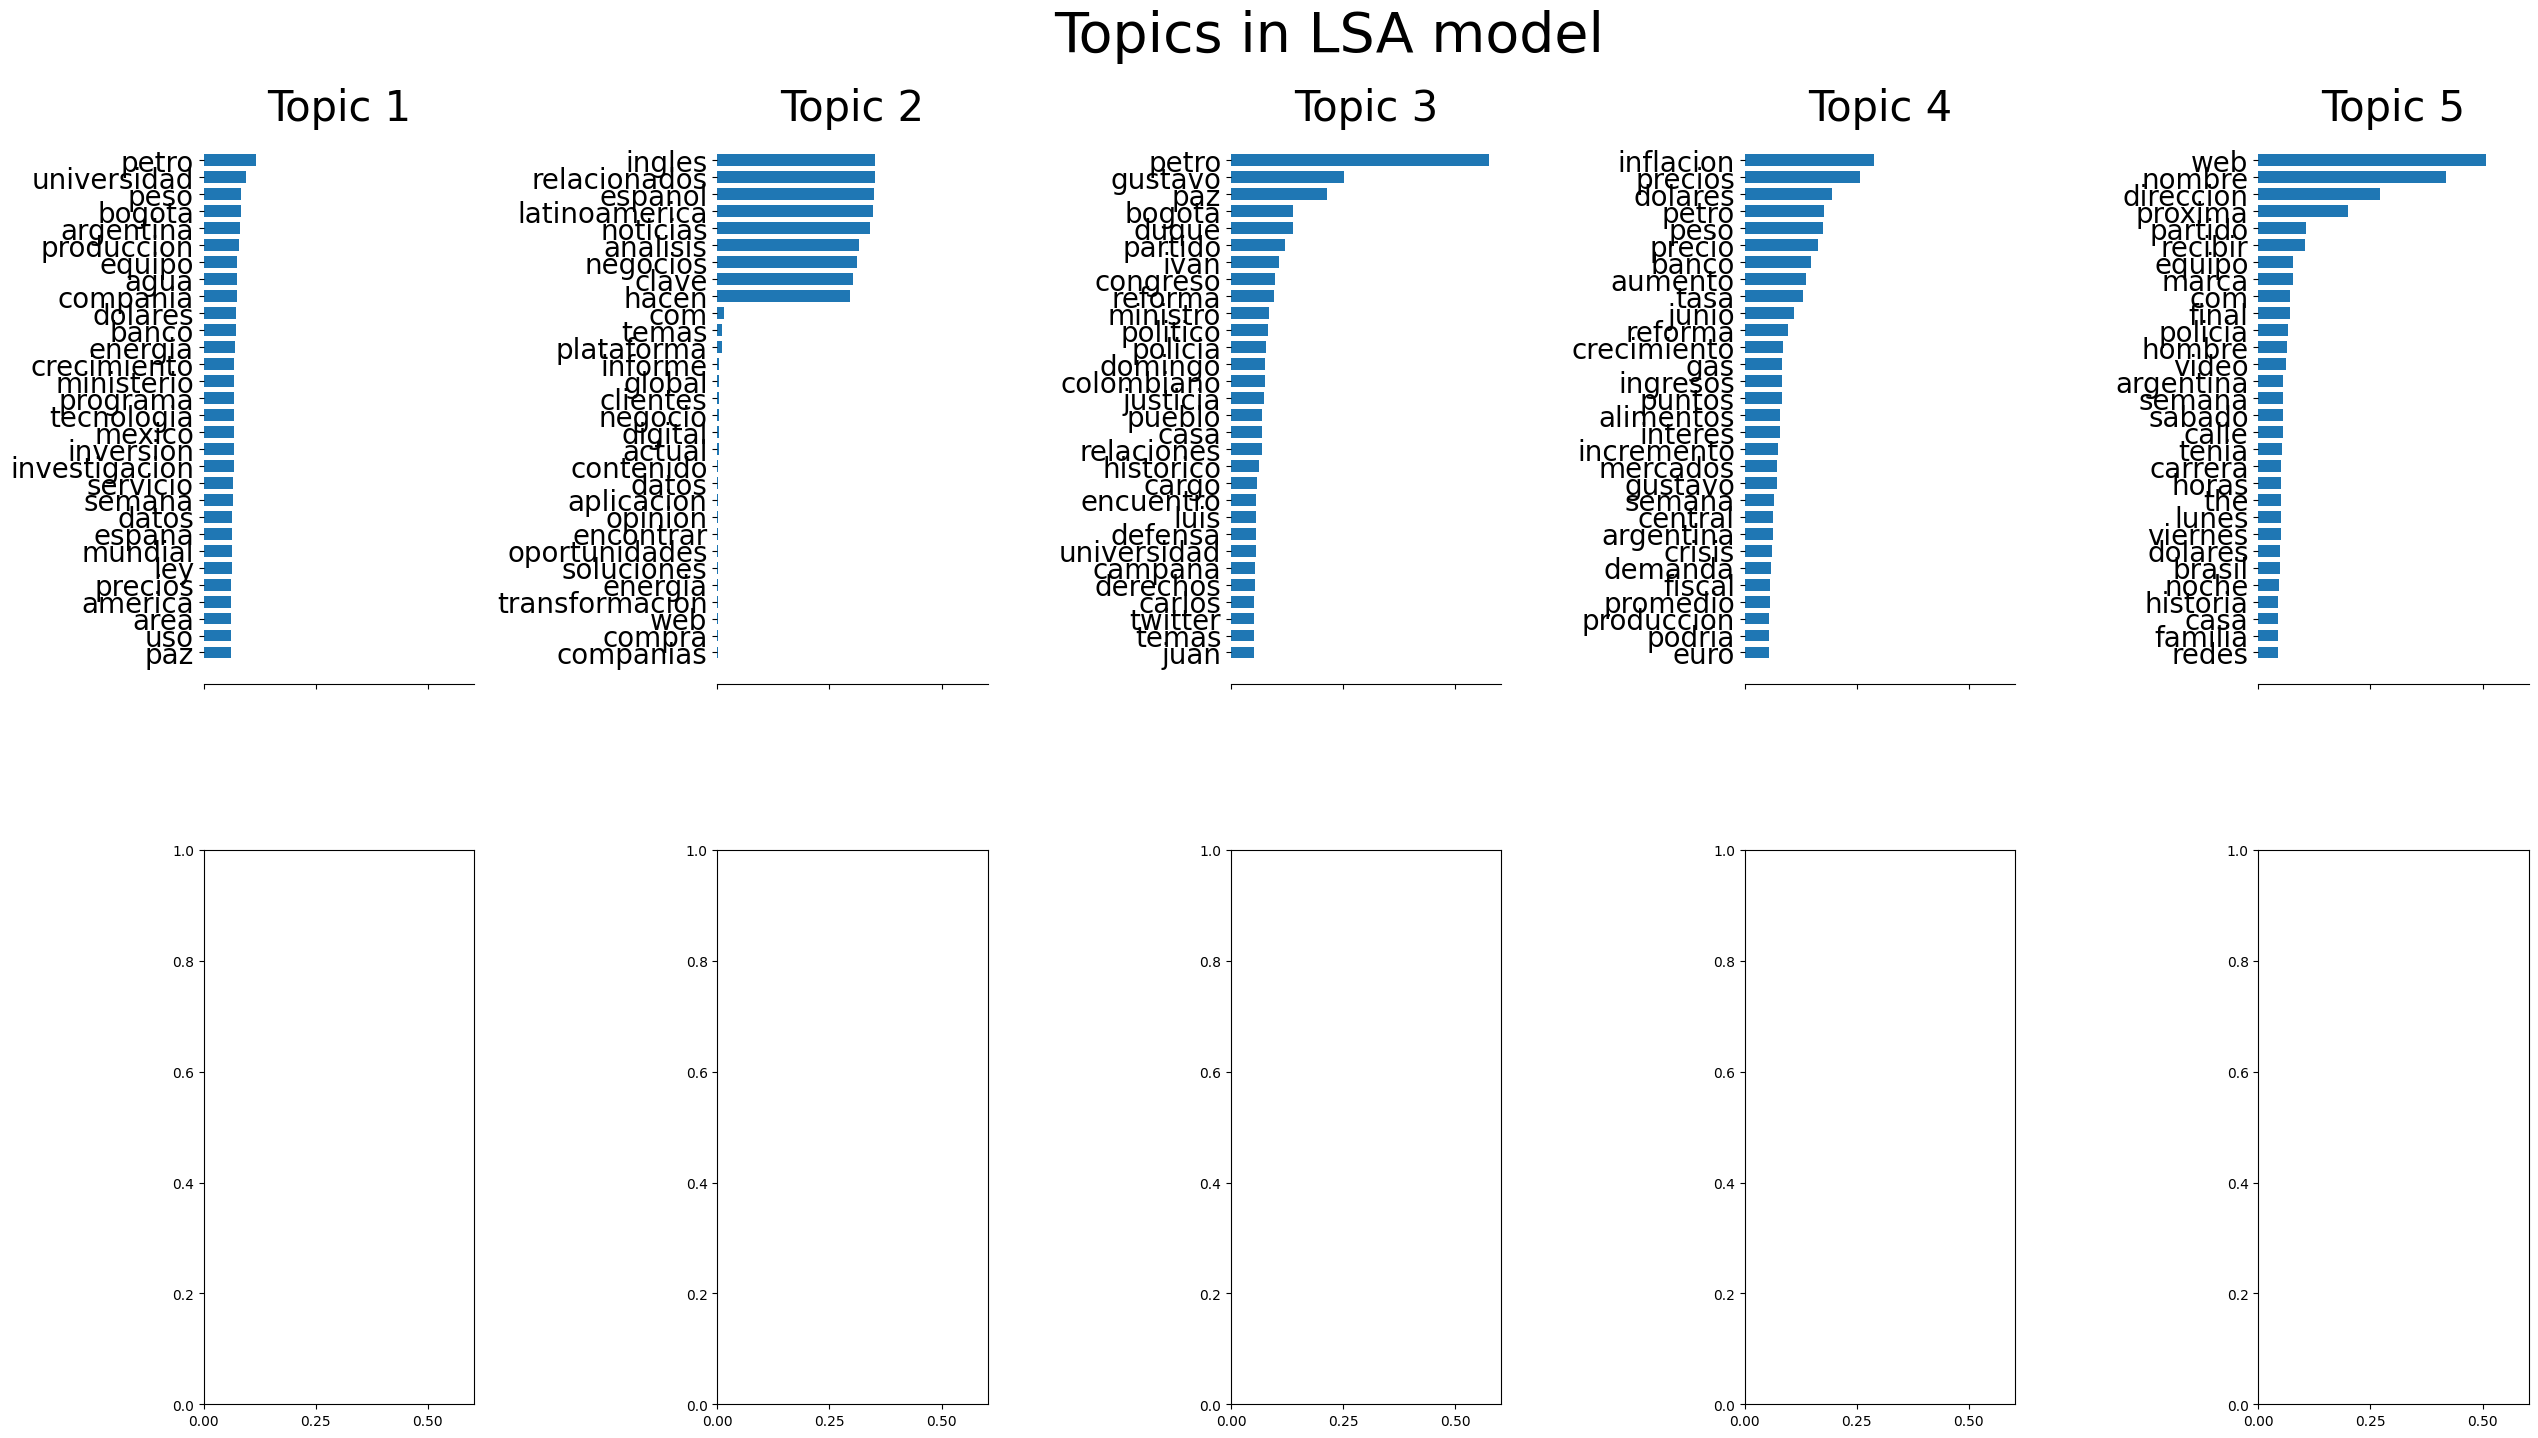

In [16]:
top_words_to_analyze = 30
plot_top_words(
    lsa_obj, words, top_words_to_analyze, "Topics in LSA model"
)

In [17]:
from sklearn.decomposition import NMF

words = np.array(tfidf.get_feature_names_out())

# Applying Non-Negative Matrix Factorization
 
nmf = NMF(n_components=n_topics, solver="mu")
W = nmf.fit_transform(news_tfidf) #Documentos a topicos
H = nmf.components_

In [18]:
print(W[0])

[4.68843206e-12 5.85946375e-36 7.67693969e-10 6.69045184e-02
 7.21287861e-08]


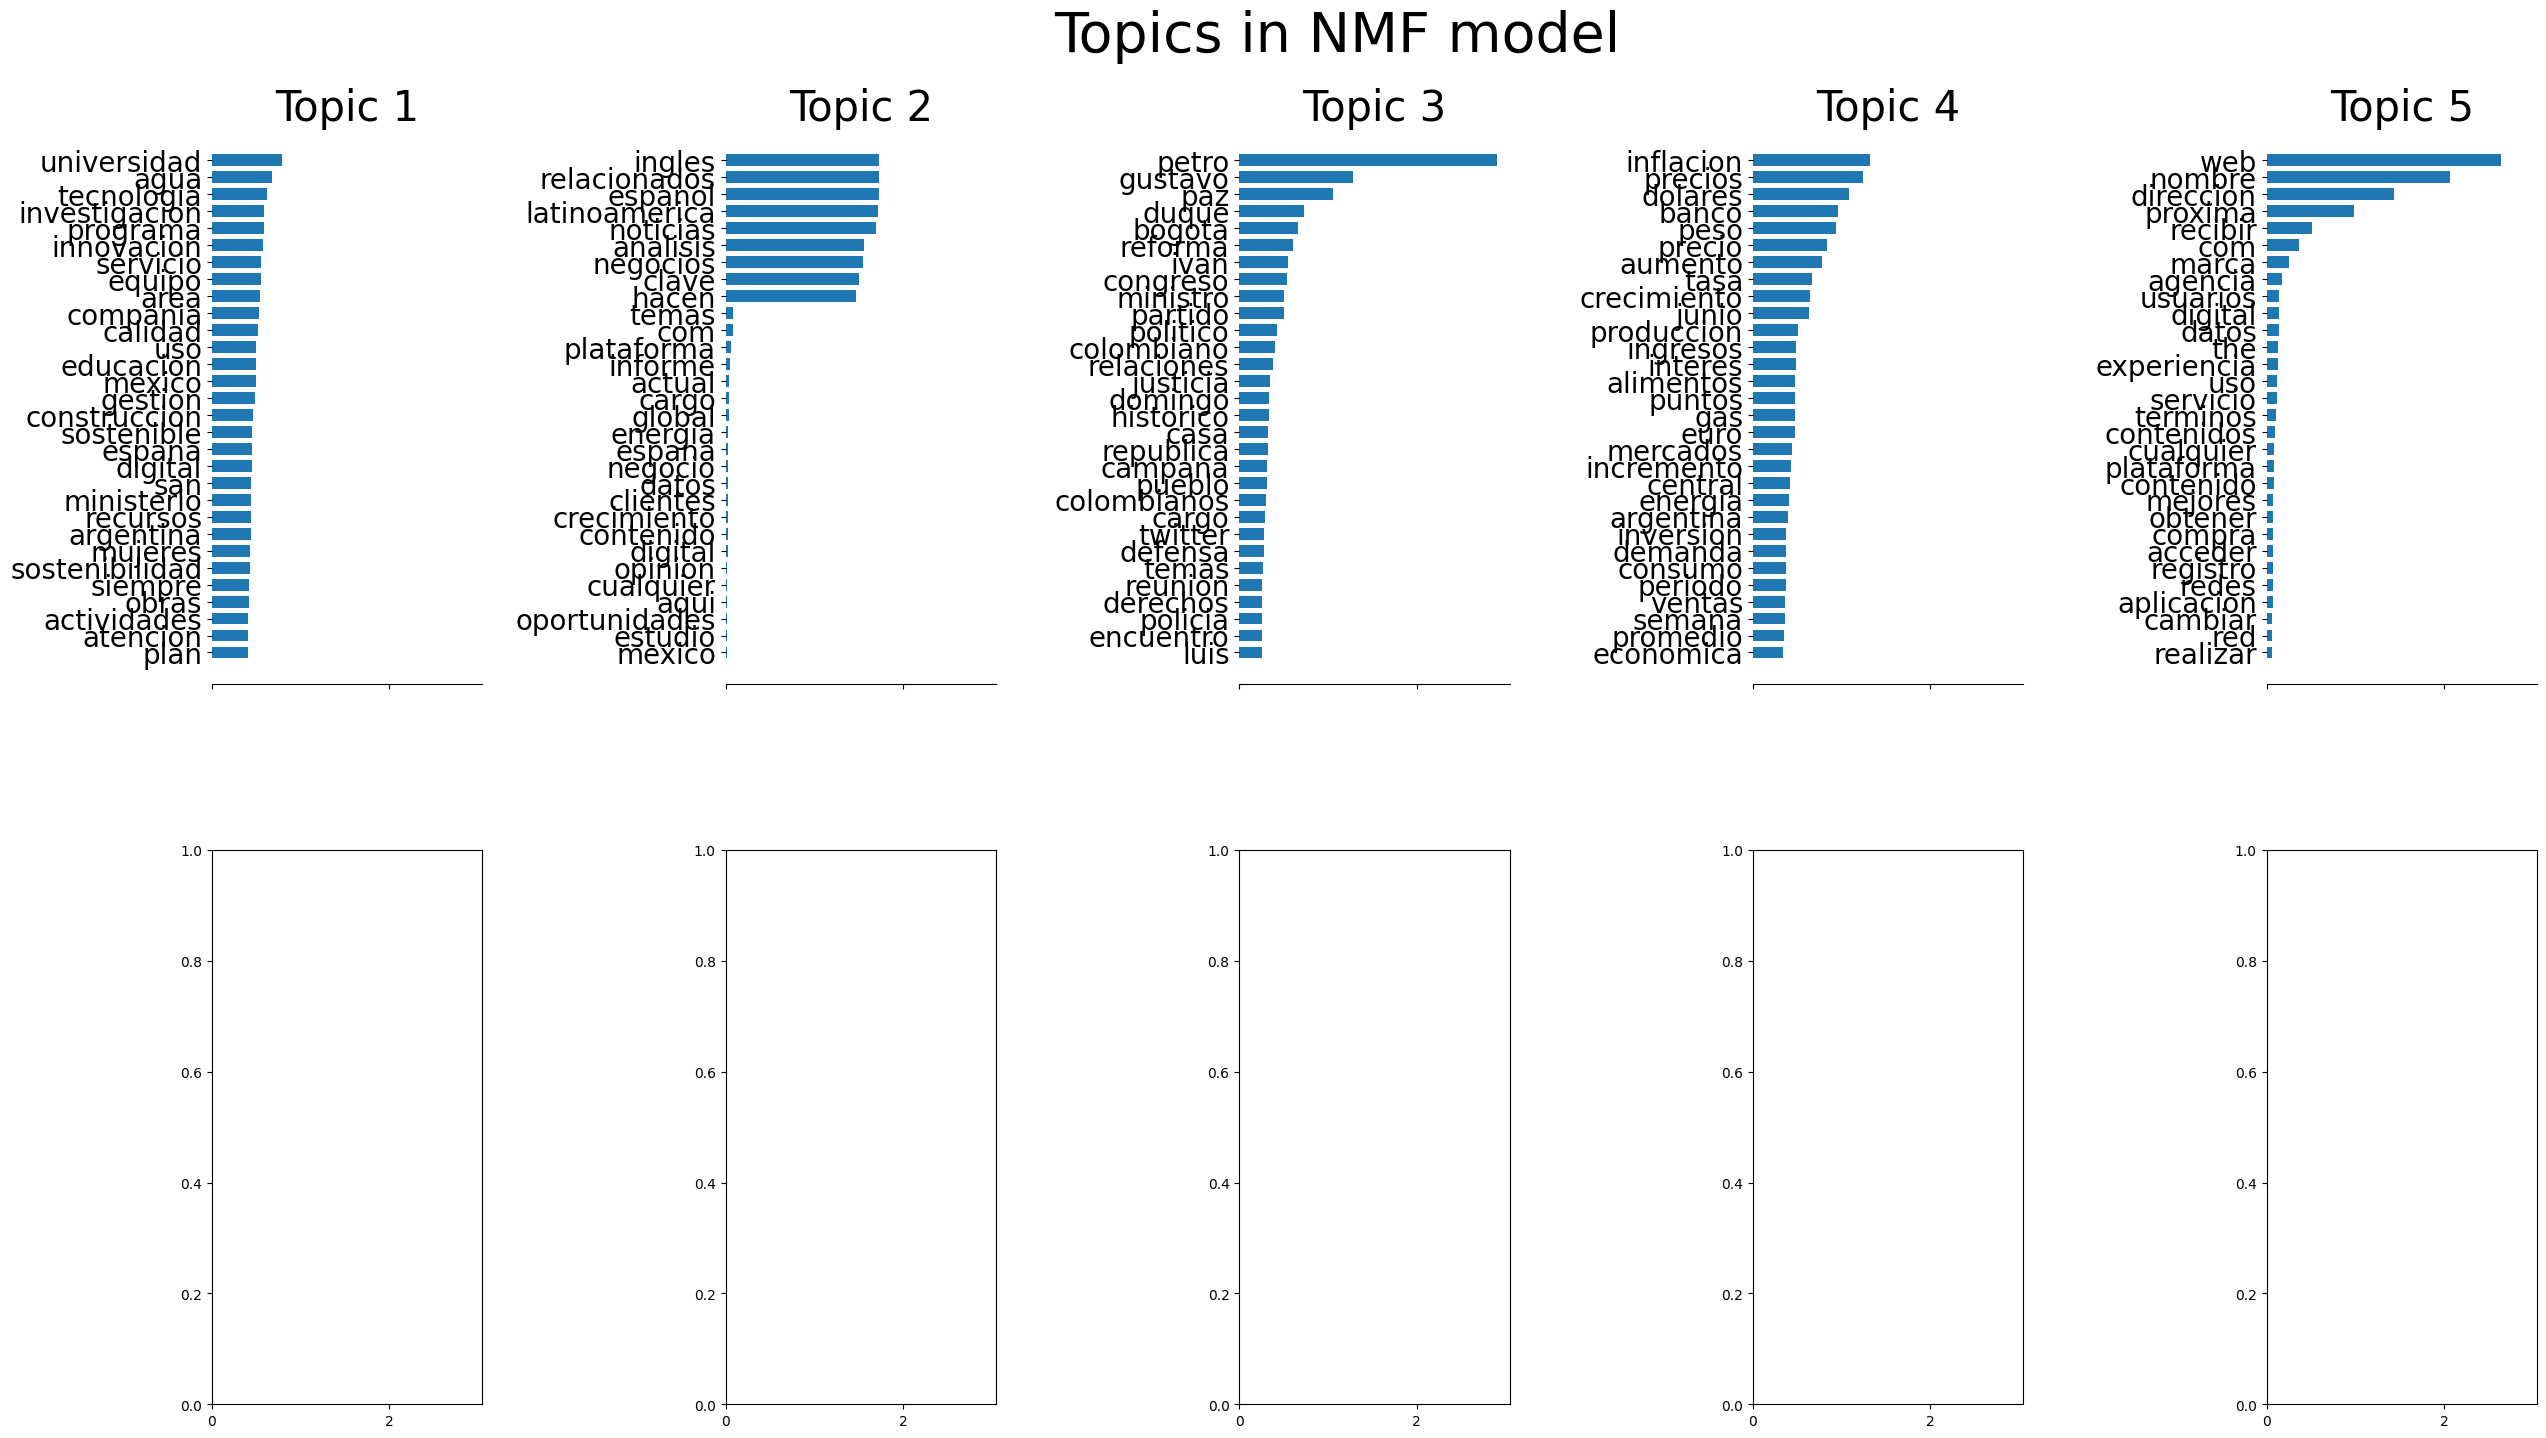

In [19]:
top_words_to_analyze = 30
plot_top_words(
    nmf, words, top_words_to_analyze, "Topics in NMF model"
)

In [20]:
from scipy._lib.doccer import inherit_docstring_from
import numpy as np

categories_rep = {}
for category in categories.columns:
  print(f"---------------- {category} --------------")
  key_list = categories[category]
  cat_vector = []
  init = False
  missing_words_count = 0
  for key in key_list.dropna():
    try:
      if not init:
        init = True
        cat_vector = np.array(model.wv[key])
      else:
        cat_vector = (cat_vector + np.array(model.wv[key]))/2
    except KeyError:
      missing_words_count += 1
      continue
  print(f"Palabras faltantes: {missing_words_count}")
  categories_rep[category] = cat_vector

---------------- regulaciones --------------
Palabras faltantes: 0
---------------- innovacion --------------
Palabras faltantes: 0
---------------- sostenibilidad --------------
Palabras faltantes: 0
---------------- macroeconomia --------------
Palabras faltantes: 0
---------------- reputacion --------------
Palabras faltantes: 0
---------------- alianzas --------------
Palabras faltantes: 0


Representacion en word2vec para cada topico

In [21]:
topics_rep = {}
for topic_idx, topic in enumerate(nmf.components_):
  print(f"---------------- Topico {topic_idx} --------------")
  top_features_ind = topic.argsort()[: -top_words_to_analyze - 1 : -1]
  weights = topic[top_features_ind]
  norm_weights = weights/sum(weights)
  init = False
  missing_words_count = 0
  keywords_count = 0
  
  for i in top_features_ind:
    topic_keyword = words[i]


    try:
      if not init:
        init = True
        topic_vector = np.array(model.wv[topic_keyword])*norm_weights[keywords_count]
      else:
        topic_vector = (topic_vector + np.array(model.wv[topic_keyword]*norm_weights[keywords_count]))/2
    except KeyError:
      missing_words_count += 1
      continue

  topics_rep[topic_idx] = topic_vector
  print(f"Palabras faltantes: {missing_words_count}")


---------------- Topico 0 --------------
Palabras faltantes: 0
---------------- Topico 1 --------------
Palabras faltantes: 0
---------------- Topico 2 --------------
Palabras faltantes: 0
---------------- Topico 3 --------------
Palabras faltantes: 0
---------------- Topico 4 --------------
Palabras faltantes: 0


In [22]:
import math

from scipy import spatial


def calculate_cosine_distance(a, b):
    cosine_distance = float(spatial.distance.cosine(a, b))
    return cosine_distance


def calculate_cosine_similarity(a, b):
    cosine_similarity = 1 - calculate_cosine_distance(a, b)
    return cosine_similarity

In [23]:
word = categories["sostenibilidad"][0]
word_vec = np.array(model.wv[word])

In [24]:
print(f"Distancias para {word}")
for category in categories_rep:

  similarity = calculate_cosine_similarity(word_vec, categories_rep[category])
  print(f"Categoria: {category}: Similaridad: {similarity}")

Distancias para agua
Categoria: regulaciones: Similaridad: 0.38554733991622925
Categoria: innovacion: Similaridad: 0.335637629032135
Categoria: sostenibilidad: Similaridad: 0.456076443195343
Categoria: macroeconomia: Similaridad: 0.21804353594779968
Categoria: reputacion: Similaridad: 0.2938828766345978
Categoria: alianzas: Similaridad: 0.31816568970680237


In [25]:
relevance_matrix = pd.DataFrame()
for category in categories_rep:
  relevance_per_topic = []

  print(f"\nCategoria: {category}")
  for topic in topics_rep:
    similarity = calculate_cosine_similarity(topics_rep[topic], categories_rep[category])
    relevance_per_topic.append(similarity)
    print(f"Similaridad al topico {topic}: {similarity}")
  if relevance_matrix.empty:
    relevance_matrix = pd.DataFrame({category: relevance_per_topic})
  else:
    relevance_matrix[category] =  relevance_per_topic
relevance_matrix.head()


Categoria: regulaciones
Similaridad al topico 0: 0.5963073372840881
Similaridad al topico 1: 0.5301465392112732
Similaridad al topico 2: 0.4166790544986725
Similaridad al topico 3: 0.5728413462638855
Similaridad al topico 4: 0.5806586146354675

Categoria: innovacion
Similaridad al topico 0: 0.5894253849983215
Similaridad al topico 1: 0.5242477655410767
Similaridad al topico 2: 0.3711000382900238
Similaridad al topico 3: 0.4753014147281647
Similaridad al topico 4: 0.6616554856300354

Categoria: sostenibilidad
Similaridad al topico 0: 0.5923007130622864
Similaridad al topico 1: 0.48343098163604736
Similaridad al topico 2: 0.3326076865196228
Similaridad al topico 3: 0.614772617816925
Similaridad al topico 4: 0.459515780210495

Categoria: macroeconomia
Similaridad al topico 0: 0.4339601993560791
Similaridad al topico 1: 0.47036755084991455
Similaridad al topico 2: 0.33580464124679565
Similaridad al topico 3: 0.6302170753479004
Similaridad al topico 4: 0.3693302273750305

Categoria: reputa

,regulaciones,innovacion,sostenibilidad,macroeconomia,reputacion,alianzas
0,0.596307,0.589425,0.592301,0.433960,0.438201,0.552503
1,0.530147,0.524248,0.483431,0.470368,0.473441,0.531709
2,0.416679,0.371100,0.332608,0.335805,0.338815,0.405672
3,0.572841,0.475301,0.614773,0.630217,0.596635,0.523701
4,0.580659,0.661655,0.459516,0.369330,0.412740,0.597038


In [26]:
similarity_matrix = W.dot(relevance_matrix.to_numpy())
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.columns = categories_rep.keys()
# TODO: Filtrar por OTROS
similarity_df['Category'] = similarity_df.idxmax(axis=1)
similarity_df.head()

,regulaciones,innovacion,sostenibilidad,macroeconomia,reputacion,alianzas,Category
0,0.038326,0.031800,0.041131,0.042164,0.039918,0.035038,macroeconomia
1,0.046792,0.041330,0.046012,0.043776,0.042560,0.043631,regulaciones
2,0.055288,0.049187,0.044384,0.044821,0.045161,0.053774,regulaciones
3,0.040219,0.038333,0.039375,0.035284,0.035025,0.038106,regulaciones
4,0.040179,0.038257,0.039356,0.035335,0.035061,0.038064,regulaciones


In [27]:
noticias['news_text_content'][1]

'No hay nada mas permanente que lo temporal y asi ocurrio con el impuesto del 4 x 1.000 con el que se gravaron algunas operaciones financieras. Aunque multiples veces se han radicado proyectos de ley en el Congreso de la Republica para desmontarlo, hasta el momento ninguno ha tenido exito y ya tiene 24 anos de vigencia en Colombia. Este impuesto, tambien conocido como gravamen a los movimientos financieros (GMF), nacio para hacerle frente a la crisis bancaria por la que estaba pasando el pais en 1998 y, en ese entonces, se esperaba que su vigencia fuera solo por un ano. Sin embargo, su eliminacion se fue postergando con el pasar de los anos porque se convirtio en una fuente de financiacion para la reconstruccion de zonas afectadas por el terremoto del Eje Cafetero (1999) y ayudo a enfrentar la crisis de 2014 por el desplome de los precios de petroleo, que afecto fuertemente los ingresos de la nacion. Al parecer, despues de 24 anos de vigencia este impuesto podria llegar a su fin en Col

<Axes: >

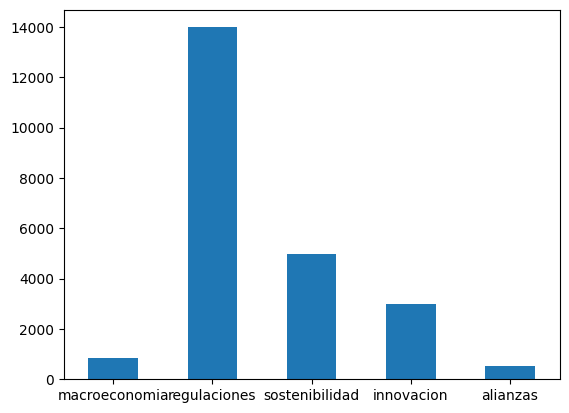

In [28]:
import seaborn as sns
similarity_df['Category'].value_counts(sort=False).plot.bar(rot=0)


In [42]:
noticias[similarity_df['Category'] == "alianzas"]

,index,Unnamed: 0,news_id,news_url_absolute,news_init_date,news_final_date,news_title,news_text_content,clean_text
25,25,25,news10112,https://www.bnamericas.com/es/noticias/ecuador...,2022-07-15,2022-07-30,Ecuador cuenta con su primer hub de innovacion,"+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
38,38,38,news10150,https://www.bnamericas.com/es/analisis/economi...,2022-07-15,2022-07-30,Economia de Brasil tendra mejor desempeno que ...,"+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
59,59,59,news10222,https://www.bnamericas.com/es/noticias/dbrs-mo...,2022-07-15,2022-07-30,"DBRS Morningstar confirma Argentina en CCC, ...","+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
96,96,96,news10375,https://www.bnamericas.com/es/reportajes/miner...,2022-07-15,2022-07-30,Mineras lidian con demandas por salarios y b...,"+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
194,194,194,news10711,https://www.bnamericas.com/es/noticias/interca...,2022-07-30,2022-08-14,Intercambio comercial de Peru por TLC supera...,"+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
...,...,...,...,...,...,...,...,...,...
22827,22876,22876,news98020,https://www.bnamericas.com/es/entrevistas/delf...,2022-07-30,2022-08-14,"Delfia: ""Queremos ofrecer una curaduria inteli...","+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
23311,23360,23360,news99930,https://www.bnamericas.com/es/noticias/argenti...,2022-07-30,2022-08-14,Argentina Pampa Energia esta atenta a senales ...,"+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
23312,23361,23361,news99932,https://www.bnamericas.com/es/noticias/producc...,2022-07-30,2022-08-14,Produccion peruana de petroleo y gas cae tra...,"+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...
23316,23365,23365,news99969,https://www.bnamericas.com/es/noticias/perfora...,2022-07-15,2022-07-30,Perforaciones del 2T en Mexico mostrarian tend...,"+21,000 proyectos en Latinoamerica. +28,600 e...",proyectos latinoamerica empresas mundo hacen n...


Silhouette Score: 0.01
Calinski-Harabasz Index: 3479.62
Davies-Bouldin Index: 2.68


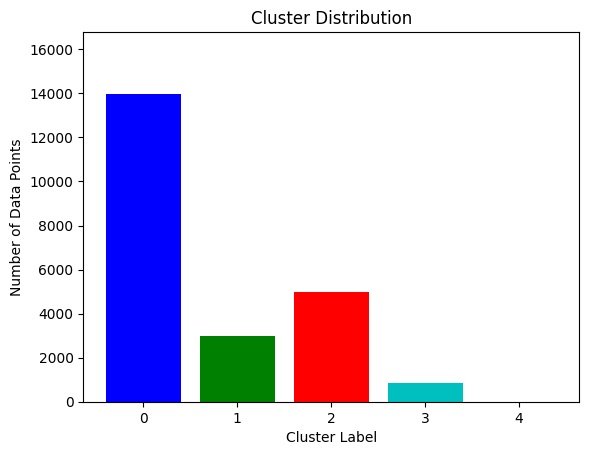

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Realiza el clustering
n_topics = 5
nmf = NMF(n_components=n_topics, solver="mu")
W = nmf.fit_transform(news_tfidf)
similarity_matrix = W.dot(relevance_matrix.to_numpy())

# Obtiene las etiquetas predichas (en este caso, los índices del máximo valor en cada fila)
etiquetas_predichas = similarity_matrix.argmax(axis=1)

# Calcula el coeficiente de silueta
silhouette_avg = silhouette_score(similarity_matrix, etiquetas_predichas)

# Calcula otras medidas de rendimiento
ch_score = calinski_harabasz_score(similarity_matrix, etiquetas_predichas)
db_score = davies_bouldin_score(similarity_matrix, etiquetas_predichas)

# Imprime los resultados
print(f'Silhouette Score: {silhouette_avg:.2f}')
print(f'Calinski-Harabasz Index: {ch_score:.2f}')
print(f'Davies-Bouldin Index: {db_score:.2f}')

# Colores de la Universidad EAFIT de Colombia (ajustados al número de clusters)
colores = ['b', 'g', 'r', 'c', 'm']

# Gráfico de barras
plt.bar(range(n_topics), [list(etiquetas_predichas).count(i) for i in range(n_topics)], color=colores)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.title('Cluster Distribution')
plt.xticks(range(n_topics))
plt.ylim(0, max([list(etiquetas_predichas).count(i) for i in range(n_topics)]) * 1.2)  # Ajustar escala del eje y
plt.show()

Silhouette Score: El Silhouette Score es una medida de evaluación comúnmente utilizada para evaluar la cohesión y separación de los clusters. Proporciona un valor entre -1 y 1, donde un valor más cercano a 1 indica una mejor separación entre los clusters. En tu caso, un valor de 0.01 indica una separación mínima entre los clusters. Si bien no es un valor muy alto, es positivo y sugiere que existe cierta estructura en los datos.

Calinski-Harabasz Index: El Índice Calinski-Harabasz es otra medida utilizada para evaluar la calidad de los clusters. Calcula la relación entre la dispersión dentro de los clusters y la dispersión entre los clusters. Un valor más alto indica una mejor separación entre los clusters. En tu caso, un valor de 3479.59 es bastante alto, lo que sugiere que hay una buena separación entre los clusters.

Davies-Bouldin Index: El Índice Davies-Bouldin es una medida que evalúa la "bondad" de los clusters. Cuanto más bajo sea el valor, mejor será la calidad de los clusters. Un valor de 2.68 indica que los clusters tienen una calidad moderada, pero podría haber margen de mejora.

Los puntos agrupados por color representan diferentes clusters o grupos obtenidos mediante el algoritmo de clasificación no supervisada. La línea creciente sugiere que los puntos dentro de cada grupo están más cerca entre sí que de los puntos en otros grupos.

Esto puede interpretarse como una separación efectiva de los datos en grupos distintos, donde los puntos dentro de cada grupo son más similares entre sí en términos de características o propiedades. Mientras que los puntos entre diferentes grupos pueden tener diferencias más marcadas.

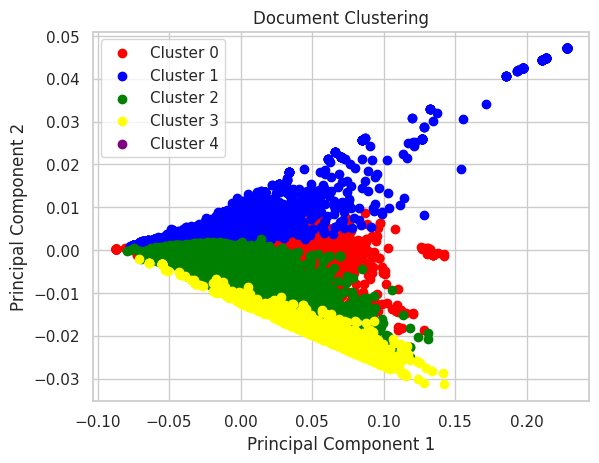

In [60]:
# Gráfico de dispersión
# Realiza la reducción de dimensionalidad utilizando PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(similarity_matrix)
for cluster in range(n_topics):
    plt.scatter(reduced_features[etiquetas_predichas == cluster, 0], reduced_features[etiquetas_predichas == cluster, 1], color=colores[cluster], label=f'Cluster {cluster}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Document Clustering')
plt.legend()
plt.show()